#Model definition

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
#import pytorch_colors as colors
import numpy as np

class enhance_net_nopool(nn.Module):

	def __init__(self):
		super(enhance_net_nopool, self).__init__()

		self.relu = nn.ReLU(inplace=True)

		number_f = 32
		self.e_conv1 = nn.Conv2d(3,number_f,3,1,1,bias=True)
		self.e_conv2 = nn.Conv2d(number_f,number_f,3,1,1,bias=True)
		self.e_conv3 = nn.Conv2d(number_f,number_f,3,1,1,bias=True)
		self.e_conv4 = nn.Conv2d(number_f,number_f,3,1,1,bias=True)
		self.e_conv5 = nn.Conv2d(number_f*2,number_f,3,1,1,bias=True)
		self.e_conv6 = nn.Conv2d(number_f*2,number_f,3,1,1,bias=True)
		self.e_conv7 = nn.Conv2d(number_f*2,24,3,1,1,bias=True)

		self.maxpool = nn.MaxPool2d(2, stride=2, return_indices=False, ceil_mode=False)
		self.upsample = nn.UpsamplingBilinear2d(scale_factor=2)



	def forward(self, x):

		x1 = self.relu(self.e_conv1(x))
		# p1 = self.maxpool(x1)
		x2 = self.relu(self.e_conv2(x1))
		# p2 = self.maxpool(x2)
		x3 = self.relu(self.e_conv3(x2))
		# p3 = self.maxpool(x3)
		x4 = self.relu(self.e_conv4(x3))

		x5 = self.relu(self.e_conv5(torch.cat([x3,x4],1)))
		# x5 = self.upsample(x5)
		x6 = self.relu(self.e_conv6(torch.cat([x2,x5],1)))

		x_r = F.tanh(self.e_conv7(torch.cat([x1,x6],1)))
		r1,r2,r3,r4,r5,r6,r7,r8 = torch.split(x_r, 3, dim=1)


		x = x + r1*(torch.pow(x,2)-x)
		x = x + r2*(torch.pow(x,2)-x)
		x = x + r3*(torch.pow(x,2)-x)
		enhance_image_1 = x + r4*(torch.pow(x,2)-x)
		x = enhance_image_1 + r5*(torch.pow(enhance_image_1,2)-enhance_image_1)
		x = x + r6*(torch.pow(x,2)-x)
		x = x + r7*(torch.pow(x,2)-x)
		enhance_image = x + r8*(torch.pow(x,2)-x)
		r = torch.cat([r1,r2,r3,r4,r5,r6,r7,r8],1)
		return enhance_image_1,enhance_image,r

#Dataloader func

In [ ]:
import os
import sys

import torch
import torch.utils.data as data

import numpy as np
from PIL import Image
import glob
import random
import cv2

random.seed(1143)


def populate_train_list(lowlight_images_path):

	image_list_lowlight = glob.glob(lowlight_images_path + "*.jpg")

	train_list = image_list_lowlight

	random.shuffle(train_list)

	return train_list



class lowlight_loader(data.Dataset):
	def __init__(self, images_name, dataset_folder):
		self.image_name_list = images_name
		self.size = 256
		self.dataset_folder = dataset_folder

	def __getitem__(self, index):
		data_lowlight = Image.open(f'{self.dataset_folder}/low/{self.image_name_list[index]}')
		data_highlight = Image.open(f'{self.dataset_folder}/high/{self.image_name_list[index]}')

		data_lowlight = data_lowlight.resize((self.size, self.size), Image.LANCZOS)
		data_highlight = data_highlight.resize((self.size, self.size), Image.LANCZOS)

		data_lowlight = (np.asarray(data_lowlight) / 255.0)
		data_lowlight = torch.from_numpy(data_lowlight).float()

		data_highlight = (np.asarray(data_highlight) / 255.0)
		data_highlight = torch.from_numpy(data_highlight).float()

		data_lowlight, data_highlight = data_lowlight.permute(2, 0, 1), data_highlight.permute(2, 0, 1)

		return data_lowlight.cuda(), data_highlight.cuda()

	def __len__(self):
		return len(self.image_name_list)

#Unpacking dataset

In [ ]:
import zipfile

with zipfile.ZipFile('drive/MyDrive/data/dataset.zip') as fh:
  fh.extractall()

In [ ]:
! mkdir -p data/test_data
! mkdir -p data/train_data

In [ ]:
! mv ./dataset/* ./data/train_data/

In [ ]:
! pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 12.3 MB/s eta 0:00:00


#Main cell eval on train data

In [ ]:
import os
import torch
import numpy as np

from torchmetrics.image import PeakSignalNoiseRatio as PSNR
from torchmetrics.image import StructuralSimilarityIndexMeasure as SSIM
from torchmetrics.image import LearnedPerceptualImagePatchSimilarity as LPIPS
from torch.utils.data import DataLoader

import time

def get_metrics(enh_img: torch.Tensor, gt_img: torch.Tensor, device: str='cpu'):
    '''
        Функция для измерения метрик. Расчитывает среднее значение по сэмплу
        Arguments:
            :enh_img: изображения после обработки
            :gt_img: ground-truth изображения
            :device: cpu/cuda
    '''
    batch_size = enh_img.shape[0]
    enh_img = enh_img.to(device)
    gt_img = gt_img.to(device)
    # PSNR
    psnr = PSNR(data_range=batch_size).to(device)
    psnr_score = psnr(enh_img, gt_img).item()
    # SSIM
    ms_ssim = SSIM(data_range=batch_size).to(device)
    ssim_score = ms_ssim(enh_img, gt_img).item()
    # LILPS
    lpips = LPIPS('alex').to(device)
    lpips_score = lpips(enh_img, gt_img).item()
    return psnr_score, ssim_score, lpips_score


def evaluate(batch_size, device='cpu', dataset_path='data/train_data'):
    '''Оценка метрик решения'''

    img_names = os.listdir(dataset_path+'/low')
    dataset = lowlight_loader(img_names, dataset_path)
    dataloader = DataLoader(dataset, batch_size=batch_size)

    with torch.no_grad():
      DCE_net = enhance_net_nopool().cuda()
      DCE_net.load_state_dict(torch.load('Epoch23.pth', map_location=torch.device(device)))

      psnr_list = np.array([])
      ssim_list = np.array([])
      lpips_list = np.array([])
      times = np.array([])
      i = 0
      times = []
      for lowlight_img, gt_img in dataloader:

          # Улучшение качества изображения
          start = time.time()
          _, enhanced_image, _ = DCE_net(lowlight_img)

          end_time = (time.time() - start)
          times.append(end_time)
          ################################
          psnr_score, ssim_score, lpips_score = get_metrics(enhanced_image, gt_img, device=device)

          psnr_list = np.append(psnr_list, psnr_score)
          ssim_list = np.append(ssim_list, ssim_score)
          lpips_list = np.append(lpips_list, lpips_score)
          i += 1
          print(f'{i}: PSNR {psnr_score}, SSIM: {ssim_score} LPIPS: {lpips_score}')

      print(f'PSNR: {psnr_list.mean()}\nSSIM: {ssim_list.mean()}\nLPIPS: {lpips_list.mean()}')
      return times


t = evaluate(2, 'cuda')
print(np.mean(t))

1: PSNR 16.05521011352539, SSIM: 0.6916563510894775 LPIPS: 0.29635563492774963
2: PSNR 20.785627365112305, SSIM: 0.7182631492614746 LPIPS: 0.24576537311077118
3: PSNR 21.183032989501953, SSIM: 0.8290022015571594 LPIPS: 0.15387147665023804
4: PSNR 15.656041145324707, SSIM: 0.684227466583252 LPIPS: 0.25057509541511536
5: PSNR 16.616683959960938, SSIM: 0.6258874535560608 LPIPS: 0.2599548101425171
6: PSNR 20.635116577148438, SSIM: 0.6683135628700256 LPIPS: 0.3333955407142639
7: PSNR 20.582529067993164, SSIM: 0.6843503713607788 LPIPS: 0.257912278175354
8: PSNR 16.36697006225586, SSIM: 0.7627185583114624 LPIPS: 0.19880366325378418
9: PSNR 19.692546844482422, SSIM: 0.687778651714325 LPIPS: 0.3442476987838745
10: PSNR 23.207395553588867, SSIM: 0.7555869221687317 LPIPS: 0.20786505937576294
11: PSNR 20.210750579833984, SSIM: 0.6540966033935547 LPIPS: 0.2740985155105591
12: PSNR 17.342567443847656, SSIM: 0.5605624914169312 LPIPS: 0.3657718598842621
13: PSNR 16.276216506958008, SSIM: 0.72467684745

#Example work

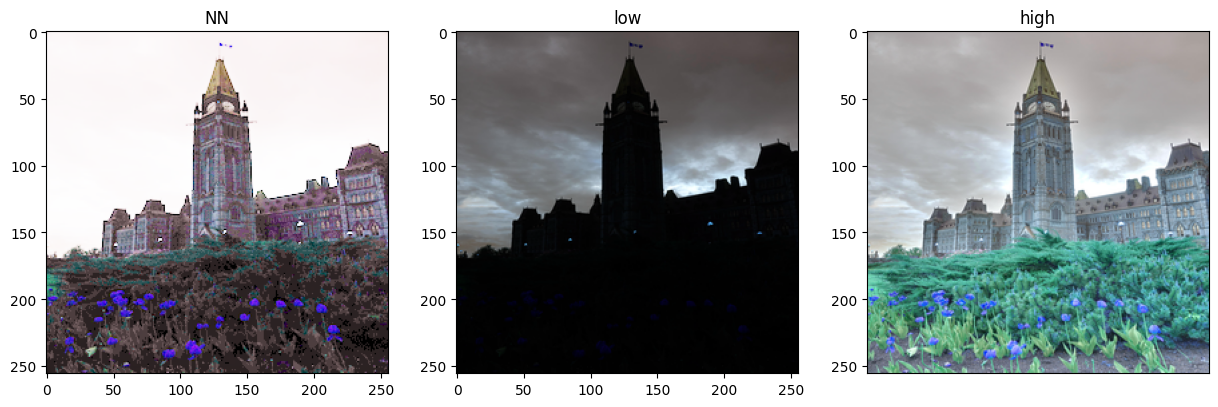

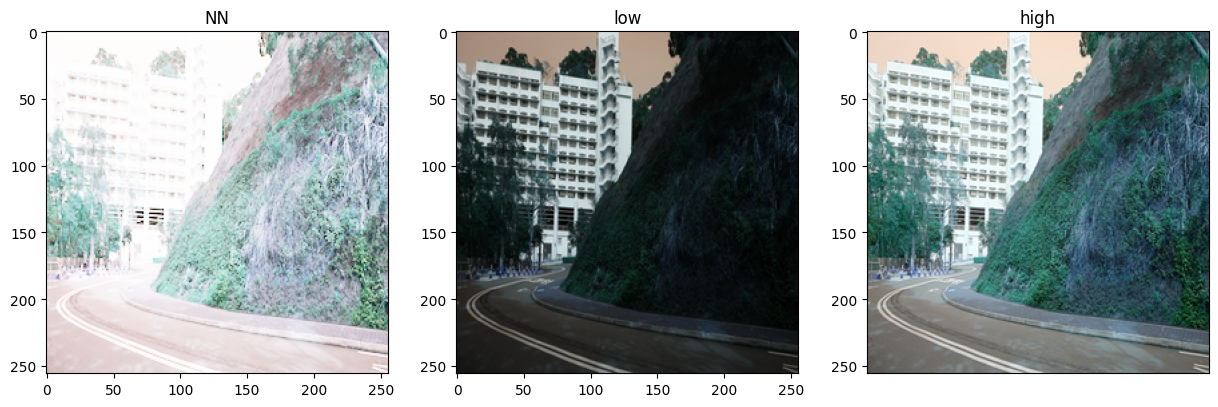

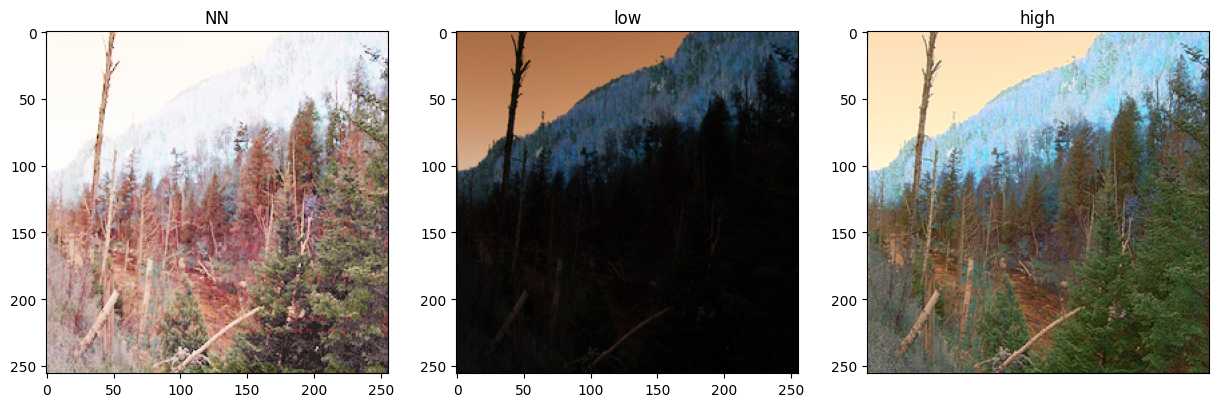

<Figure size 1500x1500 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import cv2

DCE_net = enhance_net_nopool().cuda()
DCE_net.load_state_dict(torch.load('Epoch23.pth', map_location=torch.device('cuda')))

img_names = os.listdir('data/train_data/low')
dataset = lowlight_loader(img_names, 'data/train_data')
dataloader = DataLoader(dataset, batch_size=1)

i=0


for lowlight_img, gt_img in dataloader:
  _, enhanced_image, _ = DCE_net(lowlight_img)
  plt.figure(figsize=(15, 15))

  i+=1
  if i > 3:
    break

  enhanced_image = (enhanced_image.cpu() * 255.0)
  enhanced_image = enhanced_image.int()
  reshaped = np.array(enhanced_image.permute(0, 2, 3, 1))
  reshaped = reshaped.astype('uint8')
  # print(reshaped.shape)
  reshaped = cv2.cvtColor(reshaped[0], cv2.COLOR_RGB2BGR)

  plt.subplot(1,3,1)
  plt.title('NN')
  plt.imshow(reshaped)
  # plt.show()

  #  data_lowlight = (enhanced_image.cpu() * 255.0)
	# data_lowlight = torch.from_numpy(data_lowlight.int())

  lowlight_img = (lowlight_img.cpu() * 255.0)
  lowlight_img = lowlight_img.int()
  reshaped = np.array(lowlight_img.permute(0, 2, 3, 1))
  reshaped = reshaped.astype('uint8')
  # print(reshaped.shape)
  reshaped = cv2.cvtColor(reshaped[0], cv2.COLOR_RGB2BGR)

  plt.subplot(1,3,2)
  plt.title('low')
  plt.imshow(reshaped)

  gt_img = (gt_img.cpu() * 255.0)
  gt_img = gt_img.int()
  reshaped = np.array(gt_img.permute(0, 2, 3, 1))
  reshaped = reshaped.astype('uint8')
  # print(reshaped.shape)
  reshaped = cv2.cvtColor(reshaped[0], cv2.COLOR_RGB2BGR)

  plt.subplot(1,3,3)
  plt.title('high')
  plt.imshow(reshaped)

  plt.xticks(ticks=[])
  plt.show()

  # print(lowlight_img.shape)
  # print(enhanced_image.shape)

# Test set work

In [ ]:
with zipfile.ZipFile('drive/MyDrive/data/test_set.zip') as fh:
  fh.extractall()

In [ ]:
! mv ./test_set/* ./data/test_data/

In [ ]:
t = evaluate(2, 'cuda', './data/test_data')
print(np.mean(t))

1: PSNR 18.614917755126953, SSIM: 0.6118055582046509 LPIPS: 0.26716864109039307
2: PSNR 23.53424644470215, SSIM: 0.8437322378158569 LPIPS: 0.13267399370670319
3: PSNR 19.83909797668457, SSIM: 0.8089762926101685 LPIPS: 0.15625903010368347
4: PSNR 16.532350540161133, SSIM: 0.7127254605293274 LPIPS: 0.20061452686786652
5: PSNR 17.457624435424805, SSIM: 0.6816222667694092 LPIPS: 0.29605209827423096
6: PSNR 24.0357723236084, SSIM: 0.7160869836807251 LPIPS: 0.2290593981742859
7: PSNR 17.216459274291992, SSIM: 0.7743932008743286 LPIPS: 0.2423986792564392
8: PSNR 25.835350036621094, SSIM: 0.8050369024276733 LPIPS: 0.15976688265800476
9: PSNR 17.64396095275879, SSIM: 0.7741999626159668 LPIPS: 0.19407866895198822
10: PSNR 19.801742553710938, SSIM: 0.8215828537940979 LPIPS: 0.13858067989349365
11: PSNR 23.70841407775879, SSIM: 0.7519404888153076 LPIPS: 0.16406485438346863
12: PSNR 18.278587341308594, SSIM: 0.6904765367507935 LPIPS: 0.2272845059633255
13: PSNR 14.354917526245117, SSIM: 0.638573527

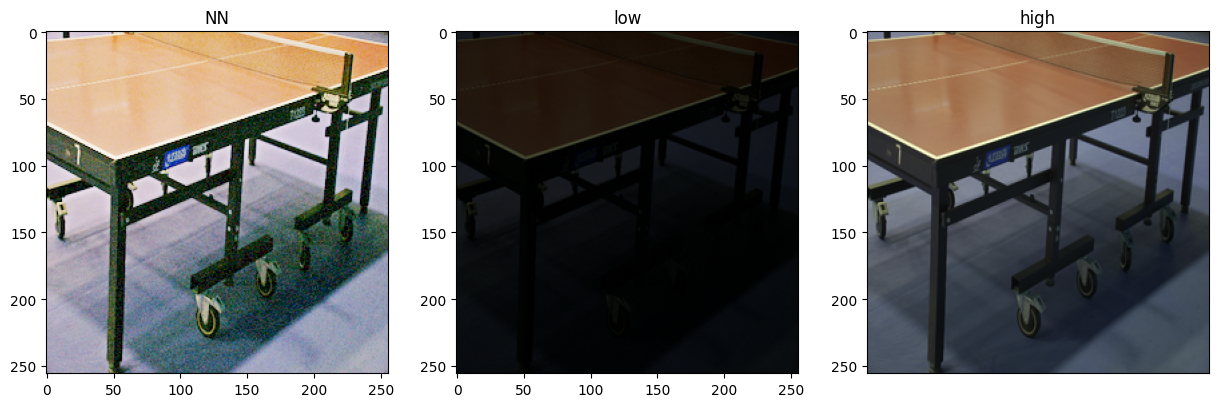

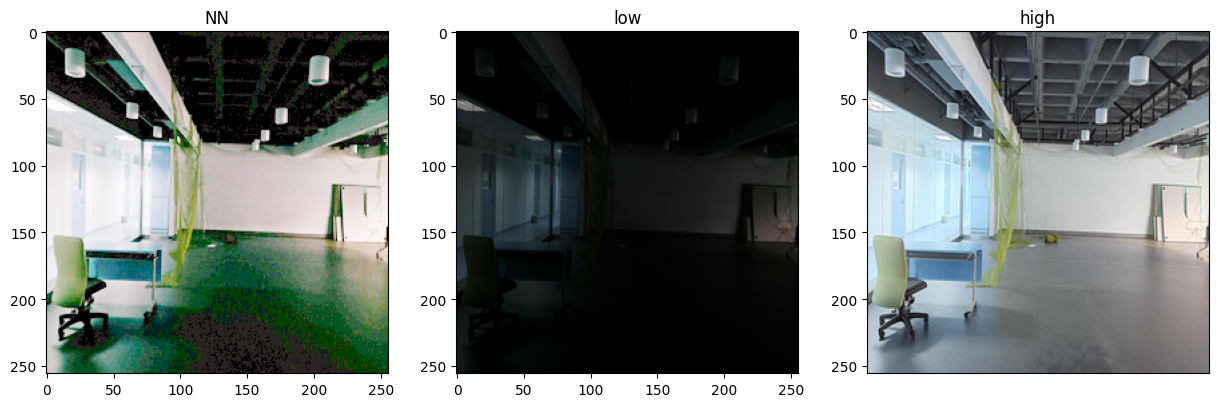

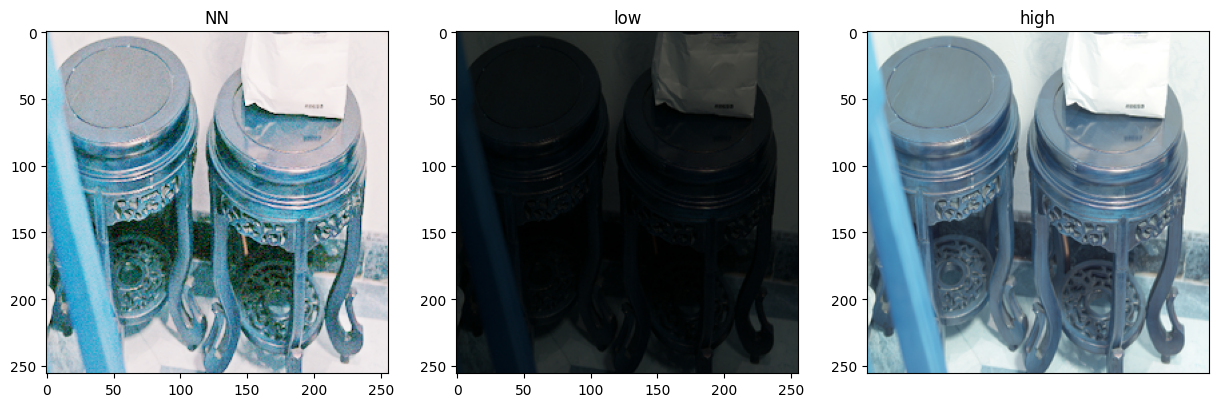

<Figure size 1500x1500 with 0 Axes>

In [ ]:
DCE_net = enhance_net_nopool().cuda()
DCE_net.load_state_dict(torch.load('Epoch23.pth', map_location=torch.device('cuda')))

img_names = os.listdir('data/test_data/low')
dataset = lowlight_loader(img_names, 'data/test_data')
dataloader = DataLoader(dataset, batch_size=1)

i=0


for lowlight_img, gt_img in dataloader:
  _, enhanced_image, _ = DCE_net(lowlight_img)
  plt.figure(figsize=(15, 15))

  i+=1
  if i > 3:
    break

  enhanced_image = (enhanced_image.cpu() * 255.0)
  enhanced_image = enhanced_image.int()
  reshaped = np.array(enhanced_image.permute(0, 2, 3, 1))
  reshaped = reshaped.astype('uint8')
  # print(reshaped.shape)
  reshaped = cv2.cvtColor(reshaped[0], cv2.COLOR_RGB2BGR)

  plt.subplot(1,3,1)
  plt.title('NN')
  plt.imshow(reshaped)
  # plt.show()

  #  data_lowlight = (enhanced_image.cpu() * 255.0)
	# data_lowlight = torch.from_numpy(data_lowlight.int())

  lowlight_img = (lowlight_img.cpu() * 255.0)
  lowlight_img = lowlight_img.int()
  reshaped = np.array(lowlight_img.permute(0, 2, 3, 1))
  reshaped = reshaped.astype('uint8')
  # print(reshaped.shape)
  reshaped = cv2.cvtColor(reshaped[0], cv2.COLOR_RGB2BGR)

  plt.subplot(1,3,2)
  plt.title('low')
  plt.imshow(reshaped)

  gt_img = (gt_img.cpu() * 255.0)
  gt_img = gt_img.int()
  reshaped = np.array(gt_img.permute(0, 2, 3, 1))
  reshaped = reshaped.astype('uint8')
  # print(reshaped.shape)
  reshaped = cv2.cvtColor(reshaped[0], cv2.COLOR_RGB2BGR)

  plt.subplot(1,3,3)
  plt.title('high')
  plt.imshow(reshaped)

  plt.xticks(ticks=[])
  plt.show()